In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import numpy as np

In [2]:
file_mat = 'logl_test_data.mat'
# list all varaiables in Matlab file file_mat
sp.io.whosmat(file_mat)

[('Cd_3', (20, 20), 'double'),
 ('d0_1', (1, 15), 'double'),
 ('d0_2', (1, 155), 'double'),
 ('d0_3', (1, 20), 'double'),
 ('dstd_1', (1, 15), 'double'),
 ('dstd_2', (1, 155), 'double'),
 ('n1', (1, 1), 'double'),
 ('n2', (1, 1), 'double'),
 ('n3', (1, 1), 'double')]

In [3]:
MAT = sp.io.loadmat(file_mat)
d0 = MAT['d0_3'].flatten()*0+10
Cd = MAT['Cd_3']
nd = d0.shape[0]


def loglikelihood(d, d_obs, d_std):
    f = -0.5 * np.sum((d_obs - d) ** 2 / (d_std ** 2))
    return f

def loglikelihood_C(d, d_obs, Cd):
    dd = d_obs - d
    # compute f = -.5 * dd^T * C^-1 * dd
    #f = -.5 * np.dot(dd.T, np.linalg.solve(Cd, dd))
    f = -.5 * np.dot(dd.T, np.dot(np.linalg.inv(Cd),dd) )
    return f

def cholesky_sim(d0, Cd):
    L=np.linalg.cholesky(Cd)
    r = np.random.normal(0,1,d0.shape[0])
    d_star = d0 + np.dot(L,r)
    return d_star

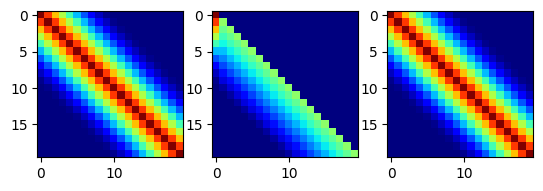

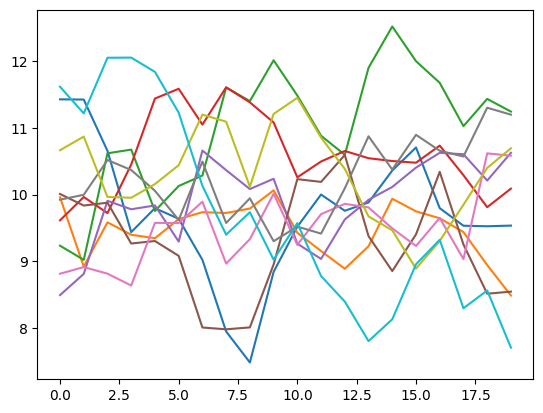

In [10]:
L=np.linalg.cholesky(Cd)

plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(Cd, cmap='jet', interpolation='none')   
plt.subplot(1,3,2)
plt.imshow(L, cmap='jet', interpolation='none')   
plt.subplot(1,3,3)
plt.imshow(np.dot(L,L.T), cmap='jet', interpolation='none')   

plt.figure()
for i in range(10):
    r = np.random.normal(0,1,d0.shape[0])
    d_star = np.dot(L.T,r)
    d_star = cholesky_sim(d0, Cd)
    plt.plot(d_star)

In [11]:
N=10000

d_sample = np.zeros((nd,N))
nlogL_sample = np.zeros((N)) # negative log likelihood
for i in range(N):
    # generate a sample from N(d0,dstd)
    d_real = cholesky_sim(d0, Cd)
    d_sample[:,i] = d_real
    nlogL_sample[i]=-loglikelihood_C(d_real, d0, Cd)    


sample_mean = np.mean(nlogL_sample)
sample_std = np.std(nlogL_sample)

normal_mean = nd/2
normal_std = np.sqrt(nd/2)

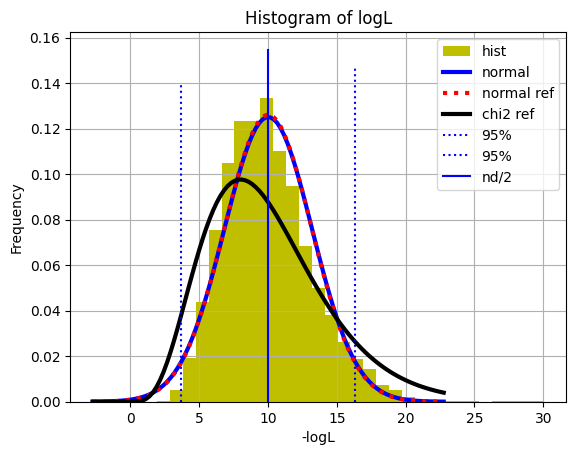

In [12]:
plt.figure()
plt.hist(nlogL_sample, bins=30, density=True, label='hist', color='y')
plt.xlabel('-logL')
plt.ylabel('Frequency')
plt.title('Histogram of logL')
# make a numpy array plt.xlim, in 100 bins
x_arr = np.linspace(sample_mean-4*sample_std, sample_mean+4*sample_std, 100)
# compute the normal distribution at x_arr
pdf_normal = sp.stats.norm(sample_mean, sample_std).pdf(x_arr)
pdf_normal_ref = sp.stats.norm(normal_mean, normal_std).pdf(x_arr)
pdf_chi2 = sp.stats.chi2(nd/2).pdf(x_arr)

plt.plot(x_arr,pdf_normal,'b-', linewidth=3, label='normal')
plt.plot(x_arr,pdf_normal_ref,'r:', linewidth=3, label='normal ref' )
plt.plot(x_arr,pdf_chi2,'k-', linewidth=3,label='chi2 ref')
plt.plot([nd/2-2*np.sqrt(nd/2),nd/2-2*np.sqrt(nd/2)],plt.ylim(),'b:', label='95%')
plt.plot([nd/2+2*np.sqrt(nd/2),nd/2+2*np.sqrt(nd/2)],plt.ylim(),'b:', label='95%')
plt.plot([nd/2,nd/2],plt.ylim(),'b-', label='nd/2')
plt.grid()
plt.legend()
plt.show()

Text(0.5, 1.0, 'True covariance')

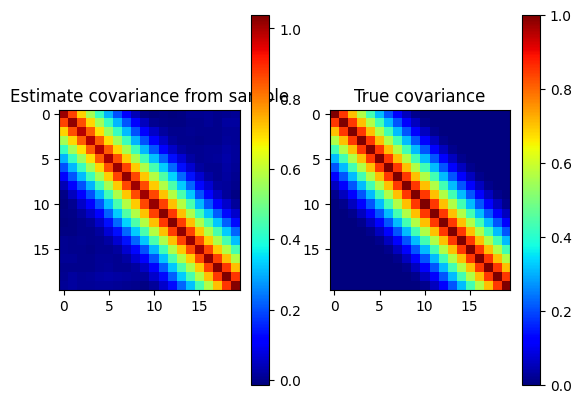

In [13]:
# create d_sample of the same size of d_sample with th evalues of d0
d0_sample = np.zeros((nd,N))
for i in range(N):
    d0_sample[:,i] = d0

Cd_est = np.dot(d_sample-d0_sample,(d_sample-d0_sample).T)/N
plt.subplot(1,2,1)
plt.imshow(Cd_est, cmap='jet', interpolation='none')
plt.colorbar()
plt.title('Estimate covariance from sample')
plt.subplot(1,2,2)
plt.imshow(Cd, cmap='jet', interpolation='none')
plt.colorbar()
plt.title('True covariance')